In [1]:
import numpy as np
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from scipy.optimize import curve_fit
import warnings

pd.set_option('display.max_rows', None)

In [2]:
root_path = Path('/Users/jiahaozhan/Desktop/data and scripts/Sivers_data')
fname = 'P10101_ByChip_Set1.csv'

data_dir = root_path / fname
df = pd.read_csv(data_dir)

print(df.columns)
# print(df[['Wave @ 100', 'Channel Spacing(nm) @ 100mA' ,'Channel Spacing(GHz) @ 100mA']])

Index(['Match Flag', 'Identity', 'Temp', 'Lot', 'Bar ID', 'Array ID',
       'Chip ID', 'Device Type', 'Design Variant', 'Pass/Fail Product',
       'Pass/Fail Power', 'Pass/Fail SMSR',
       'Pass/Fail Channel Spacing from CH1', 'Vf @ 300mA', 'Threshold If',
       'Eff @ Ith + X', 'Eff @ 1–5mW', 'R @ Ith + X', 'Power @ 300mA',
       'Eff @ 300mA', 'Eff Ratio', 'R @ 300mA', 'Max Pwr', 'Max Pwr @ I',
       'Max Kink', 'Kink If', 'Ith (2 Seg)', 'Ith (1 Der)', 'Ith (2 Der)',
       'Ith (Lin)', 'Ith (2 Poly)', 'BF Power', 'Wave @ 100', 'SMSR @ 100',
       'Peak Power @ 100', '2nd Peak', 'Peak Separation', 'Wave @ 200',
       'SMSR @ 200', 'Peak Power @ 200', 'Wave Shift', 'SMSR Delta',
       'Wave @ 300', 'SMSR @ 300', 'Peak Power @ 300', 'Wave Delta @ 100mA',
       'Wave Delta @ 200mA', 'Wave Delta @ 300mA',
       'Channel Spacing(nm) @ 100mA', 'Channel Spacing(GHz) @ 100mA',
       'Spacing Delta (GHz) @ 100mA', 'Y1', 'Y2', 'Directory', 'Test Date',
       'Pad', 'Bar_Actual', 

In [3]:
peak_wl_100 = df['Wave @ 100'].to_numpy()
peak_wl_to_center = peak_wl_100.reshape(-1, 8)
peak_wl_chan_var = np.transpose(peak_wl_to_center)
# print(peak_wl_to_center)
# print(peak_wl_chan_var)

In [4]:
for pw in peak_wl_chan_var:
    print(np.ptp(pw))

1.3699999999998909
1.5299999999999727
1.5499999999999545
1.6000000000001364
1.7100000000000364
1.6900000000000546
1.7899999999999636
1.75


20


(1315.5, 1318.5)

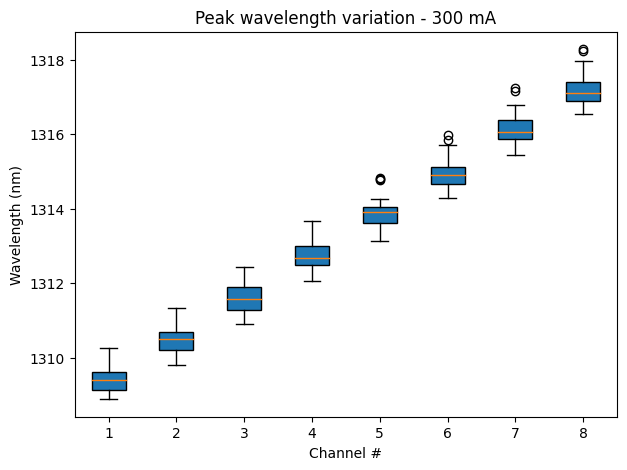

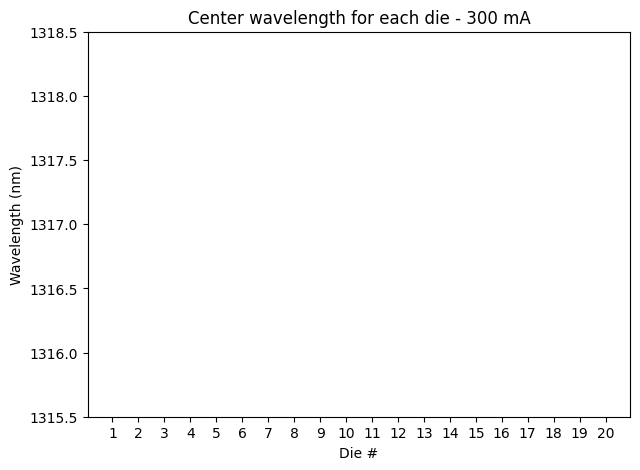

In [5]:
die = np.arange(1, 21, 1)
chans = np.arange(1, 9, 1)

center_wl = []
for wls in peak_wl_to_center:
    center_wl.append(np.average(wls))
print(len(center_wl))

# plot box plot to show peak wavelength variation
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.boxplot(peak_wl_to_center, patch_artist=True, labels=chans, showfliers=True)
ax.set_xlabel('Channel #')
ax.set_ylabel('Wavelength (nm)')
ax.set_title('Peak wavelength variation - 300 mA')

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.plot(die, center_wl, 'o')
ax.set_xlabel('Die #')
ax.set_ylabel('Wavelength (nm)')
ax.set_title('Center wavelength for each die - 300 mA')
ax.set_xticks(np.arange(1, 21, 1))
ax.set_ylim([1315.5, 1318.5])  # 100 mA: [1312, 1315], 200 mA: [1313.5, 1316.5], 300 mA: [1316, 1319]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


20


Text(0.5, 1.0, 'Channel spacing variation - 100 mA')

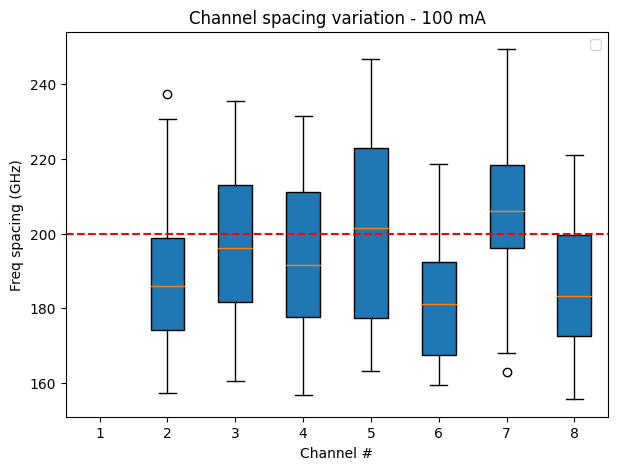

In [6]:
chan_spacing_100 = df['Channel Spacing(GHz) @ 100mA'].to_numpy()
chan_spacing_100 = chan_spacing_100.reshape(-1, 8)
print(len(chan_spacing_100))

# plot box plot to show peak channel
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.boxplot(chan_spacing_100, patch_artist=True, labels=chans, showfliers=True)
ax.set_xlabel('Channel #')
ax.set_ylabel('Freq spacing (GHz)')
ax.axhline(200, linestyle='--', color='r')
ax.legend()
ax.set_title('Channel spacing variation - 100 mA')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Channel spacing variation - 300 mA')

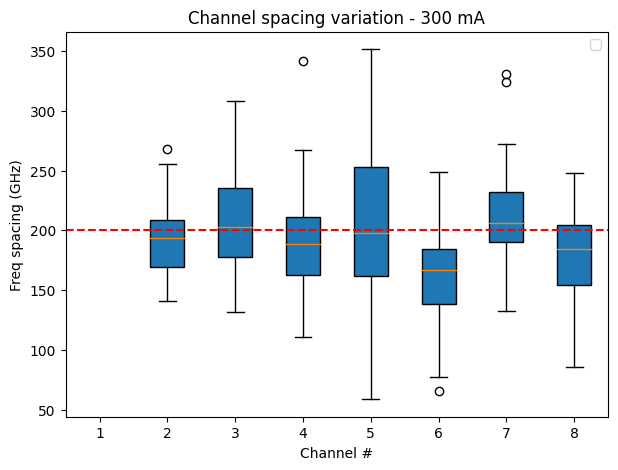

In [21]:
# extract channel spacing data at 200 mA
peak_wl_200 = df['Wave @ 300'].to_numpy()
peak_freq_200 = np.divide(3e8, peak_wl_200)
peak_freq_200 = peak_freq_200.reshape(-1, 8)
# print(peak_freq_200)

chan_spacing_200 = []
for pf in peak_freq_200:
    freq_spacing = [np.nan]
    for i in range(1, len(pf)):
        freq_spacing.append(pf[i-1] - pf[i])
    chan_spacing_200.append(freq_spacing)

chan_spacing_200 = np.transpose(chan_spacing_200)
chan_spacing_200 = np.transpose(chan_spacing_200)

# plot box plot to show channel spacing variation
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.boxplot(chan_spacing_200, patch_artist=True, labels=chans, showfliers=True)
ax.set_xlabel('Channel #')
ax.set_ylabel('Freq spacing (GHz)')
ax.axhline(200, linestyle='--', color='r')
ax.legend()
ax.set_title('Channel spacing variation - 300 mA')

In [9]:
def calc_var(data: list, pivot):
    sum = 0
    for d in data:
        sum += (d - pivot) ** 2
    return sum/len(data)

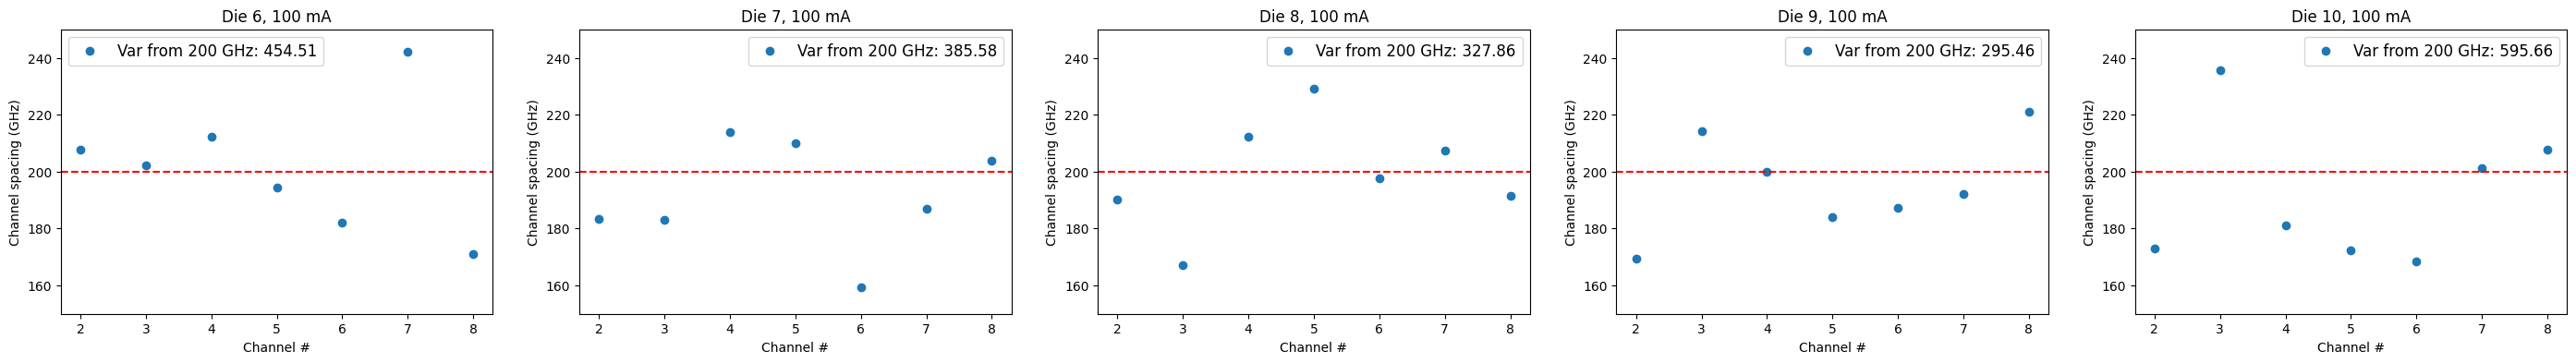

In [39]:
fig, axes = plt.subplots(1, 5, figsize=(35, 4))
g = 2
for i, s in enumerate(chan_spacing_100[5*(g-1):5*g]):
    ax = axes[i]
    ax.plot(chans, s, 'o', label=f'Var from 200 GHz: {calc_var(s[1:], 200):.2f}')
    ax.set_xlabel('Channel #')
    ax.set_ylabel('Channel spacing (GHz)')
    ax.axhline(200, linestyle='--', color='r')
    ax.set_title(f'Die {i+1+5*(g-1)}, 100 mA')
    ax.set_ylim([150, 250])
    ax.legend(prop={'size':12})